# ADABOOST ALGORITHM:-
AdaBoost means Adaptive Boosting which is a ensemble learning technique that combines multiple weak classifiers to create a strong classifier. It works by sequentially adding classifiers to correct the errors made by previous models giving more weight to the misclassified data points. 

# REFERENCES:-
📚 References for AdaBoost

1. Original Paper

Yoav Freund, Robert E. Schapire. A Decision-Theoretic Generalization of On-Line Learning and an Application to Boosting (1997).
🔗 Paper PDF



2. Introductory Reading

Schapire, R.E. Explaining AdaBoost.
🔗 PDF

In [35]:
# This notebook implements AdaBoost with decision stumps as weak learners.
# Steps:
# 1. Load and preprocess Titanic dataset (simple version with explanations).
# 2. Implement a Decision Stump and AdaBoost from scratch.
# 3. Train the model and evaluate performance.
# 4. Visualize results.


In [36]:
## Load dataset
import seaborn as sns
df=sns.load_dataset('titanic')
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [37]:
#First import the important libraries:-
import math
from dataclasses import dataclass
from typing import List, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report


In [38]:
#preprocessing
# -----------------------------
def preprocess_titanic(df: pd.DataFrame) -> Tuple[pd.DataFrame, np.ndarray]:
    """Simplified preprocessing with detailed comments."""

    # We select only a few important features to keep it simple
    features = ["pclass", "sex", "age", "fare", "embarked"]
    X = df[features].copy()

    # Target variable: Survived (1 means survived, 0 means not survived)
    # We map it to {+1, -1} for AdaBoost math
    y = np.where(df["survived"] == 1, 1, -1).astype(np.int8)

    # Handle missing values in a simple way:
    X["age"] = X["age"].fillna(X["age"].median())
    X["fare"] = X["fare"].fillna(X["fare"].median())
    X["embarked"] = X["embarked"].fillna("S")

    
    # Convert categorical features (Sex, Embarked, Pclass) into numeric form
    # One-hot encoding creates new columns (0/1) for each category
    # This way, the model can work with categorical data easily
    # One-hot encoding for categorical features
    X = pd.get_dummies(X, columns=["sex", "embarked", "pclass"], drop_first=False)

    return X.astype(np.float32), y


# Let's first understand the mathemtical concepts and formulas used behind this model:-

# 📘 AdaBoost Formulas

# 1. Weighted Error Rate

#$$\varepsilon_t = \frac{\sum_{i=1}^{N} w_i \cdot I(y_i \neq h_t(x_i))}{\sum_{i=1}^{N} w_i}$$

#w(i): weight of sample .

#I(.): indicator function (1 if condition true, else 0).
#➡️ Measures how much weight is on the misclassified samples.



#-----------------------------------------------------------------------------------------------------------------------

# 2. Learner’s Weight (Alpha)

#$$\alpha_t = \frac{1}{2} \ln \left( \frac{1 - \varepsilon_t}{\varepsilon_t} \right)$$

#➡️ If error is low,  is high (strong learner). If error is 0.5,  (random guess).


#-----------------------------------------------------------------------------------------------------------------------

# 3. Update Rule for Sample Weights

#$$w_i \leftarrow w_i \cdot e^{\alpha_t \cdot I(y_i \neq h_t(x_i))}$$

#Correctly classified samples keep lower weight.


#➡️ This forces the next learner to focus on hard-to-classify points.


#-----------------------------------------------------------------------------------------------------------------------

# 4. Normalization of Weights

#$$w_i \leftarrow \frac{w_i}{\sum_{j=1}^{N} w_j}$$


#---------------------------------------------------------------------------------------------------------------------------

# 5. Final Strong Classifier

#$$H(x) = \text{sign}\left(\sum_{t=1}^{T} \alpha_t \cdot h_t(x)\right)$$

#➡️ The ensemble makes the final decision by weighted majority vote.


#----------------------------------------------------------------------------------------------------------------

In [39]:
# Weak learner: Decision Stump
# -----------------------------

@dataclass
class DecisionStump:
    feature_index: int = -1
    threshold: float = 0.0
    polarity: int = 1

    def predict(self, X: np.ndarray) -> np.ndarray:
        col = X[:, self.feature_index]
        preds = np.ones_like(col, dtype=np.int8)
        preds[col > self.threshold] = -1
        return preds * self.polarity


# Now,using the formulas and concepts explained above,let's implement the Adaboost Classifier:-

In [40]:
# AdaBoost Classifier
# ---------------------------------

class AdaBoostClassifierScratch:
    def __init__(self, n_estimators: int = 100):
        self.n_estimators = int(n_estimators)
        self.alphas: List[float] = []
        self.stumps: List[DecisionStump] = []

    def _weighted_error(self, y_true: np.ndarray, y_pred: np.ndarray, w: np.ndarray) -> float:
         # Weighted error = sum of weights where prediction != true label
        return float(np.sum(w * (y_true != y_pred)))

    def _best_stump(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> Tuple[DecisionStump, float]:
        n_samples, n_features = X.shape
        best_stump = DecisionStump()
        best_err = np.inf
        # Try each feature and possible threshold
        for j in range(n_features):
            xj = X[:, j]
            vals = np.unique(xj)
            if vals.size == 1:
                thr_candidates = vals
            else:
                # Midpoints between unique values as possible thresholds
                mids = (vals[:-1] + vals[1:]) / 2.0
                thr_candidates = np.concatenate(([vals[0] - 1.0], mids, [vals[-1] + 1.0]))

            for thr in thr_candidates:
                stump = DecisionStump(feature_index=j, threshold=thr, polarity=1)
                pred = stump.predict(X)
                err = self._weighted_error(y, pred, w)
                 # Also test flipping polarity
                stump_flip = DecisionStump(feature_index=j, threshold=thr, polarity=-1)
                pred_flip = stump_flip.predict(X)
                err_flip = self._weighted_error(y, pred_flip, w)

                if err_flip < err:
                    err, stump = err_flip, stump_flip

                if err < best_err:
                    best_err, best_stump = err, stump

        return best_stump, float(best_err)

    def fit(self, X: np.ndarray, y: np.ndarray):
        n_samples, _ = X.shape
        # Start with equal weights for all samples
        w = np.ones(n_samples, dtype=np.float64) / n_samples

        self.alphas.clear()
        self.stumps.clear()

        self.errors = []  # store training error at each round

        for t in range(self.n_estimators):
            # Find best decision stump at this round
            stump, err = self._best_stump(X, y, w)
            # Compute alpha (stump weight)
            err = max(1e-12, min(err, 1 - 1e-12))
            alpha = 0.5 * math.log((1.0 - err) / err)

            # Update sample weights
            pred = stump.predict(X)
            w *= np.exp(-alpha * y * pred)
            w /= w.sum()

            # Save stump and its weight
            self.stumps.append(stump)
            self.alphas.append(alpha)

            # store training error for visualization
            train_pred = self.predict(X)
            self.errors.append(1 - accuracy_score(y, train_pred))

        return self

    def decision_function(self, X: np.ndarray) -> np.ndarray:
        # Combine all weak learners
        F = np.zeros(X.shape[0], dtype=np.float64)
        for alpha, stump in zip(self.alphas, self.stumps):
            F += alpha * stump.predict(X)
        return F

    def predict(self, X: np.ndarray) -> np.ndarray:
        F = self.decision_function(X)
        return np.where(F >= 0, 1, -1).astype(np.int8)

    def predict_proba(self, X: np.ndarray) -> np.ndarray:
        # Convert margin F(x) into probability
        F = self.decision_function(X)
        p1 = 1.0 / (1.0 + np.exp(-2.0 * F))
        p0 = 1.0 - p1
        return np.vstack([p0, p1]).T


In [41]:
# Training & Evaluation
# -----------------------------
X_df,y=preprocess_titanic(df)
X=X_df.values.astype(np.float32)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

model = AdaBoostClassifierScratch(n_estimators=150)
model.fit(X_train, y_train)

y_pred = model.predict(X_val)
acc = accuracy_score(y_val, y_pred)

print(f"Validation Accuracy: {acc:.4f}")
print(classification_report((y_val==1).astype(int), (y_pred==1).astype(int)))


Validation Accuracy: 0.7989
              precision    recall  f1-score   support

           0       0.82      0.86      0.84       110
           1       0.76      0.70      0.73        69

    accuracy                           0.80       179
   macro avg       0.79      0.78      0.78       179
weighted avg       0.80      0.80      0.80       179



# Now,let's understand the same thing using many visualizations:-

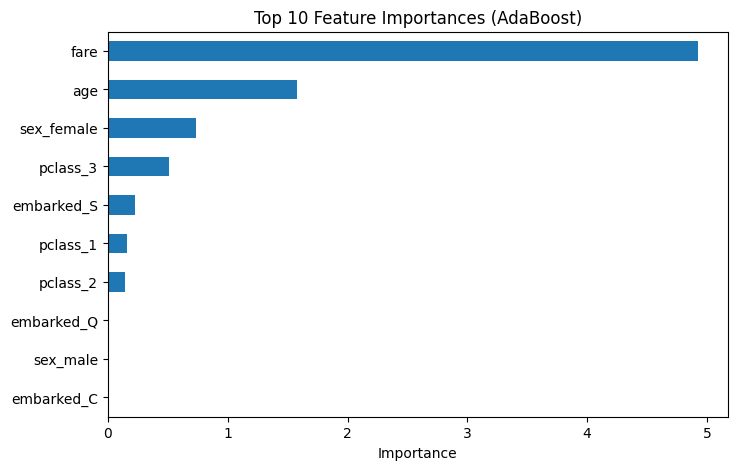

In [42]:
# 1. Feature importance
importances = np.zeros(X.shape[1], dtype=np.float64)
for alpha, stump in zip(model.alphas, model.stumps):
    importances[stump.feature_index] += abs(alpha)

fi = pd.Series(importances, index=X_df.columns).sort_values(ascending=False)

plt.figure(figsize=(8, 5))
fi.head(10).plot(kind="barh")
plt.title("Top 10 Feature Importances (AdaBoost)")
plt.xlabel("Importance")
plt.gca().invert_yaxis()
plt.show()


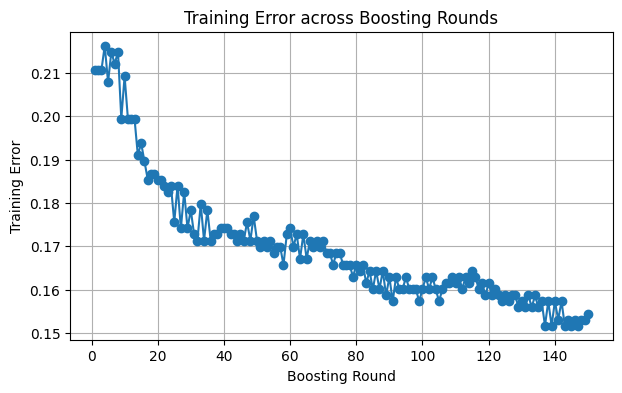

In [43]:

# 2. Training error over boosting rounds
plt.figure(figsize=(7, 4))
plt.plot(range(1, len(model.errors)+1), model.errors, marker='o')
plt.xlabel("Boosting Round")
plt.ylabel("Training Error")
plt.title("Training Error across Boosting Rounds")
plt.grid(True)
plt.show()


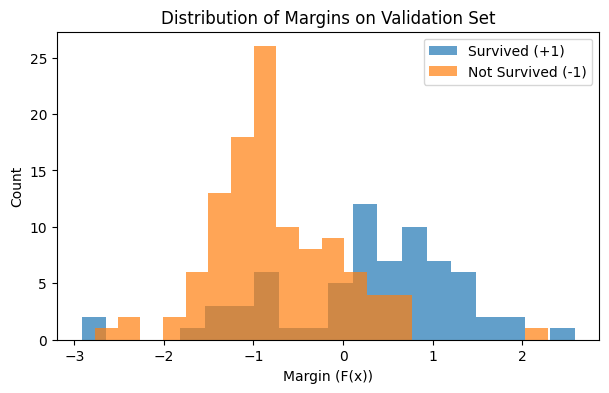

In [44]:

# 3. Distribution of margins on validation set
F_val = model.decision_function(X_val)
plt.figure(figsize=(7, 4))
plt.hist(F_val[y_val==1], bins=20, alpha=0.7, label="Survived (+1)")
plt.hist(F_val[y_val==-1], bins=20, alpha=0.7, label="Not Survived (-1)")
plt.xlabel("Margin (F(x))")
plt.ylabel("Count")
plt.title("Distribution of Margins on Validation Set")
plt.legend()
plt.show()

In [45]:
# Feature importance = sum of |alpha| values for each feature
importances = np.zeros(X.shape[1], dtype=np.float64)
for alpha, stump in zip(model.alphas, model.stumps):
    importances[stump.feature_index] += abs(alpha)

fi = pd.Series(importances, index=X_df.columns).sort_values(ascending=False)
fi.head(15)

fare          4.927596
age           1.579307
sex_female    0.738583
pclass_3      0.512576
embarked_S    0.225640
pclass_1      0.160406
pclass_2      0.142838
embarked_Q    0.000000
sex_male      0.000000
embarked_C    0.000000
dtype: float64

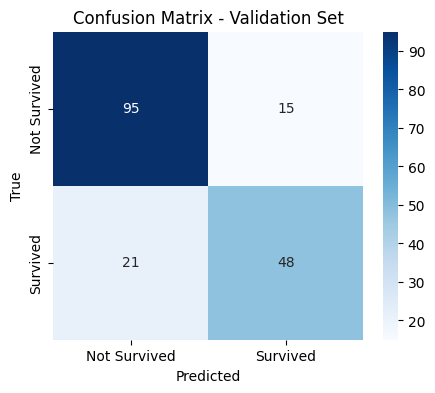

In [46]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
# 4. Confusion matrix heatmap
cm = confusion_matrix((y_val==1).astype(int), (y_pred==1).astype(int))
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Not Survived", "Survived"], yticklabels=["Not Survived", "Survived"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Validation Set")
plt.show()


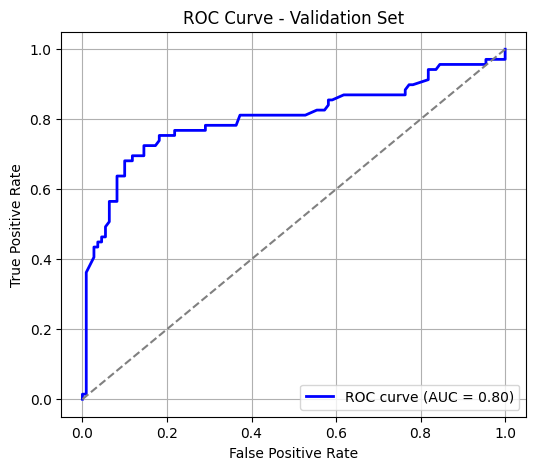

In [47]:
# 5. ROC Curve and AUC
probs = model.predict_proba(X_val)[:, 1]
fpr, tpr, _ = roc_curve((y_val==1).astype(int), probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Validation Set")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


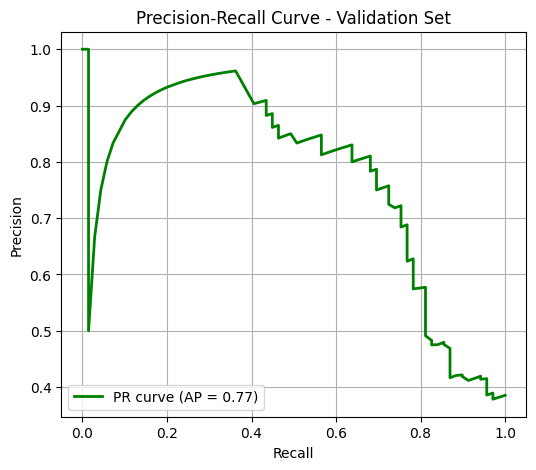

In [48]:
# 6. Precision-Recall Curve
precision, recall, _ = precision_recall_curve((y_val==1).astype(int), probs)
avg_prec = average_precision_score((y_val==1).astype(int), probs)

plt.figure(figsize=(6, 5))
plt.plot(recall, precision, color='green', lw=2, label=f'PR curve (AP = {avg_prec:.2f})')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Validation Set")
plt.legend(loc="lower left")
plt.grid(True)
plt.show()

# CONCLUSIONS:-
# Hence,we implemented Adaboost from scratch with an accuracy of ~79% and AUC=0.80, which is good.
# The main thing especiaaly about this model is that it assigns more weights to the more misclassified data-points and less alplha values(learning parameter) and vice-versa.
# Inshort:-Sample Weights Initialization: w------->Training the Weak Classifier------->Error Calculation----->Alpha Calculation--------->Updating Weights------->finally,Normalization